# EEG Visual Classification Dataset Analysis with RAPIDS
---

EEG(Electrography) Visual Classifciation Dataset [LINK](https://github.com/perceivelab/eeg_visual_classification) is one of the most popular datasets for EEG classifcation.

However, there may be some issues, as we cannot achieve consistent results with their code. 

Therefore, we need to analyze it to identify the issues and discuss them on their [Github Page](https://github.com/perceivelab/eeg_visual_classification/issues/1)

## Import Library
---

In [1]:
import os, glob
import numpy as np
import torch
import shutil

import subprocess
import logging



import cupy as cp

import dask
import dask_cudf
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})
from dask.distributed import Client, wait, progress
from dask_cuda import LocalCUDACluster

import cudf

import cuml
from cuml.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load Datasets
---


In [2]:
img_path       ="/media/NAS/EEG2IMAGE/eeg_cvpr_2017/image"
parquet_data   = sorted(glob.glob("./DATA/parquet/*"))

## Make Function
---

In [3]:
class_numbers = 2

## PCA

In [4]:
pca_lst  = []
lost_lst = []

for class_number in range(class_numbers):
    pca = PCA(n_components=2)
    class_arr = cudf.read_parquet(parquet_data[class_number]).to_cupy()
    s, n_fea = class_arr.shape
    
    X_pca = pca.fit_transform(class_arr[0].reshape(128,-1))
    class_pca = X_pca
    total_variance_retained = (pca.explained_variance_ratio_).sum()
    information_lost_percent = (1 - total_variance_retained) * 100
    
    for seg in class_arr[1:, :]:
        X_pca = pca.fit_transform(seg.reshape(128,-1))
        class_pca = cp.append(class_pca, X_pca, axis=0)
        total_variance_retained = (pca.explained_variance_ratio_).sum()
        information_lost_percent += (1 - total_variance_retained) * 100
    lost_lst.append((information_lost_percent/s).item())
    pca_lst.append(class_pca)

In [5]:
parquet_data[3]

'./DATA/parquet/11.parquet'

In [6]:
class_arr = cudf.read_parquet(parquet_data[1]).to_cupy()

In [7]:
class_arr

array([[-7.22216666e-02, -9.64620933e-02, -1.61419824e-01, ...,
        -2.65897721e-01, -1.37300855e-02, -1.17334433e-01],
       [-4.41616297e-01, -6.00774348e-01, -4.43012565e-01, ...,
         7.13685155e-02,  2.27163383e-03,  6.64454997e-02],
       [-1.15300156e-01, -1.20758913e-01,  1.23560414e-01, ...,
        -1.85207987e+00,  4.34564972e+00,  4.17397261e-01],
       ...,
       [ 2.70916015e-01,  2.09829956e-01,  2.87932372e+00, ...,
        -1.82245648e+00, -1.00150891e-01, -1.20056880e+00],
       [ 4.03394073e-01,  1.67601418e+00, -6.42627358e-01, ...,
        -9.57914412e-01, -5.42718321e-02, -5.93060791e-01],
       [ 2.93162078e-01,  1.50340188e+00, -4.72773433e-01, ...,
        -1.00829482e+00, -5.76518252e-02, -7.17820644e-01]], dtype=float32)

In [8]:
class_arr

array([[-7.22216666e-02, -9.64620933e-02, -1.61419824e-01, ...,
        -2.65897721e-01, -1.37300855e-02, -1.17334433e-01],
       [-4.41616297e-01, -6.00774348e-01, -4.43012565e-01, ...,
         7.13685155e-02,  2.27163383e-03,  6.64454997e-02],
       [-1.15300156e-01, -1.20758913e-01,  1.23560414e-01, ...,
        -1.85207987e+00,  4.34564972e+00,  4.17397261e-01],
       ...,
       [ 2.70916015e-01,  2.09829956e-01,  2.87932372e+00, ...,
        -1.82245648e+00, -1.00150891e-01, -1.20056880e+00],
       [ 4.03394073e-01,  1.67601418e+00, -6.42627358e-01, ...,
        -9.57914412e-01, -5.42718321e-02, -5.93060791e-01],
       [ 2.93162078e-01,  1.50340188e+00, -4.72773433e-01, ...,
        -1.00829482e+00, -5.76518252e-02, -7.17820644e-01]], dtype=float32)

In [9]:
pca = PCA(n_components=2)
class_arr = cudf.read_parquet(parquet_data[0]).to_cupy()
X_pca = pca.fit_transform(class_arr[0].reshape(128,-1))

In [10]:
X_pca

array([[ 2.06255317e-02, -2.72657275e-01],
       [-1.03110857e+01, -2.59325266e+00],
       [-4.25113983e+01,  3.21313972e+01],
       [-3.08438644e+01, -3.82263031e+01],
       [-9.89368629e+00, -5.04631460e-01],
       [ 1.81013596e+00, -3.80964309e-01],
       [ 1.95181668e+00,  2.09415293e+00],
       [-7.35378218e+00,  1.45530629e+00],
       [-1.76992989e+01, -7.75230646e+00],
       [-1.14247513e+01, -1.22049105e+00],
       [ 2.12662792e+00,  2.01167285e-01],
       [ 1.18020496e+01,  1.87177658e+00],
       [ 8.19524288e+00,  8.15225959e-01],
       [-6.24395251e-01,  7.42667139e-01],
       [-7.95135212e+00, -3.32219410e+00],
       [-3.67856359e+00, -1.89506173e-01],
       [ 3.51977825e+00, -1.06551737e-01],
       [ 8.60743332e+00,  2.94918418e+00],
       [ 1.19103746e+01, -7.73069763e+00],
       [-7.65664637e-01, -9.50458229e-01],
       [-4.30043411e+00,  2.92246461e-01],
       [-2.16255337e-01, -1.63400620e-01],
       [ 5.11203480e+00,  8.45492601e-01],
       [ 9.

In [11]:
pca_lst

[array([[ 2.0625532e-02, -2.7265728e-01],
        [-1.0311086e+01, -2.5932527e+00],
        [-4.2511398e+01,  3.2131397e+01],
        ...,
        [ 2.0008879e+00,  1.7044187e+00],
        [ 1.9222453e+00, -7.0778000e-01],
        [-3.1667081e-01,  2.1800146e+00]], dtype=float32),
 array([[ 0.06924103,  0.05290627],
        [ 0.79487145,  1.4138757 ],
        [ 2.51854   , -1.3779058 ],
        ...,
        [-8.926983  , -9.04498   ],
        [-0.36135566,  1.0389479 ],
        [ 8.2720585 , -4.377843  ]], dtype=float32)]

## Visualization Result

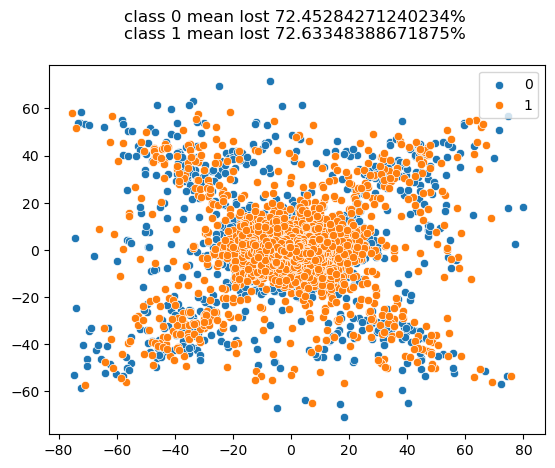

In [12]:
plt.figure()
title_string = ""

for idx, (lost, class_pca) in enumerate(zip(lost_lst, pca_lst)):
    title_string += f"class {idx} mean lost {lost}% \n"   
    class_pca = cp.asnumpy(class_pca)
    pc1, pc2 = class_pca[:, 0], class_pca[:, 1]
    sns.scatterplot(x=pc1, y=pc2, label=idx)

plt.title(title_string)
plt.show()
plt.close()

In [20]:
pca_lst[0][np.arange(0, len(pca_lst[0]), 128),: ].shape

(300, 2)

In [31]:
for channel in range(128):
    plt.figure()
    title_string = ""
    channels_lst = np.arange(channel, len(pca_lst[0]), 128) 
    
    for idx, (lost, class_pca) in enumerate(zip(lost_lst, pca_lst)):
        title_string += f"class {idx}, channel{channel}, mean lost {lost}% \n"   
        class_pca = cp.asnumpy(class_pca[channels_lst,:])
        pc1, pc2 = class_pca[:, 0], class_pca[:, 1]
        scat_plot = sns.scatterplot(x=pc1, y=pc2, label=idx)
    
    plt.title(title_string)
    # plt.show()
    fig = scat_plot.get_figure()
    fig.savefig(f"channel_{channel}.png")
    plt.close()